# Time Series Segmentation through ClaSP

This Jupyter-Notebook illustrates the usage of the *Classification Score Profile (ClaSP)* for time series segmentation. 

ClaSP hierarchically splits a TS into two parts, where each split point is determined by training a binary TS classifier for each possible split point and selecting the one with highest accuracy, i.e., the one that is best at identifying subsequences to be from either of the partitions. 

Please refer to our paper, published at CIKM '21, for details:
*P. Schäfer, A. Ermshaus, U. Leser, ClaSP - Time Series Segmentation, CIKM 2021*

Let’s import the required packages first

In [1]:
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# from matplotlib.patches import Rectangle

sns.set_theme()
sns.set_color_codes()


from sktime.annotation.clasp import ClaSPSegmentation
from sktime.datasets import load_electric_devices_segmentation

# Retrieve the data

First lets load and plot the time series to be segmented.

In [2]:
ts, period_size, true_cps = load_electric_devices_segmentation()
pd.DataFrame(ts)

,1
0,
1,-0.187086
2,0.098119
3,0.088967
4,0.107328
5,-0.193514
...,...
11528,0.300240
11529,0.200745
11530,-0.548908


# Visualizing the Time Series

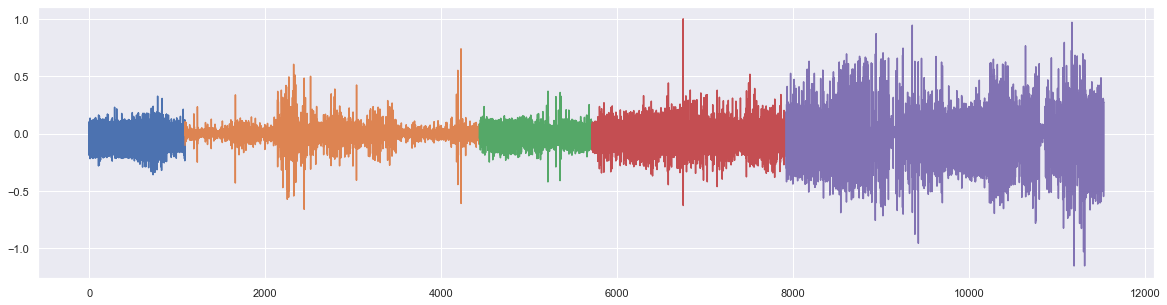

In [3]:
plt.figure(figsize=(20, 5))
segments = [0] + true_cps.tolist() + [ts.shape[0]]
for idx in np.arange(0, len(segments) - 1):
    plt.plot(
        range(segments[idx], segments[idx + 1]),
        ts[segments[idx] : segments[idx + 1]],
    )

# rect = Rectangle((880, -2), 40, 5, facecolor="lightgrey")
# plt.gca().add_patch(rect)

_ = plt.show()

The change points are around time stamps $1090,4436,5712,7923$, from which different electric devices are recorded.

# ClaSP - Classification Score Profile

Let's run ClaSP to find the true change point. 

ClaSP has two hyper-parameters:
- The period length
- The number of change points to find

The result of ClaSP is a profile in which the maximum indicates the found change points.

In [4]:
clasp = ClaSPSegmentation(period_length=period_size, n_cps=5).fit(ts)
found_cps, profiles, scores = clasp.predict(ts)

... and we visualize the results.

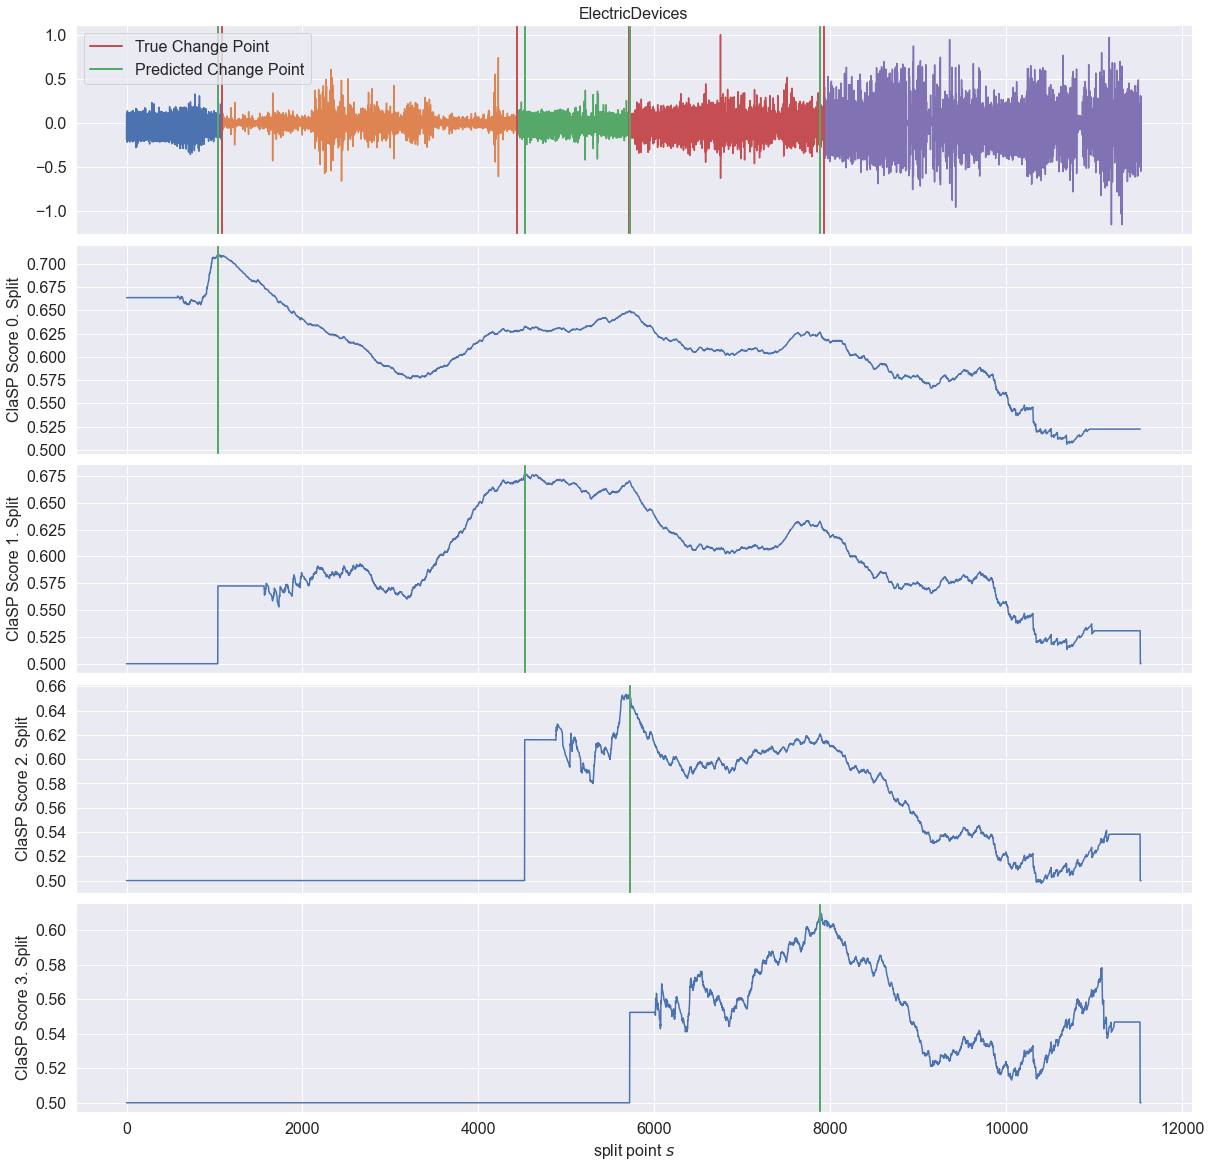

In [5]:
def plot_clasp_with_ts(
    ts_name,
    ts,
    clasp,
    true_cps=None,
    found_cps=None,
    score="ClaSP Score",
    font_size=16,
):
    fig, ax = plt.subplots(
        len(clasp) + 1,
        1,
        sharex=True,
        gridspec_kw={"hspace": 0.05},
        figsize=(20, 5 * len(clasp)),
    )
    ax = ax.reshape(-1)

    if true_cps is not None:
        segments = [0] + true_cps.tolist() + [ts.shape[0]]
        for idx in np.arange(0, len(segments) - 1):
            ax[0].plot(
                np.arange(segments[idx], segments[idx + 1]),
                ts[segments[idx] : segments[idx + 1]],
            )
    else:
        ax[0].plot(np.arange(ts.shape[0]), ts)

    for i, profile in enumerate(clasp):
        ax[i + 1].plot(np.arange(len(profile)), profile, color="b")
        ax[i + 1].set_ylabel(score + " " + str(i) + ". Split", fontsize=font_size)

    ax[-1].set_xlabel("split point $s$", fontsize=font_size)
    ax[0].set_title(ts_name, fontsize=font_size)

    for a in ax:
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)

        for tick in a.yaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)

    if true_cps is not None:
        for idx, true_cp in enumerate(true_cps):
            ax[0].axvline(
                x=true_cp,
                linewidth=2,
                color="r",
                label="True Change Point" if idx == 0 else None,
            )

    if found_cps is not None:
        for idx, found_cp in enumerate(found_cps):
            ax[0].axvline(
                x=found_cp,
                linewidth=2,
                color="g",
                label="Predicted Change Point" if idx == 0 else None,
            )
            ax[idx + 1].axvline(
                x=found_cp,
                linewidth=2,
                color="g",
                label="Predicted Change Point" if idx == 0 else None,
            )

    ax[0].legend(prop={"size": font_size})
    _ = plt.show()


plot_clasp_with_ts(
    "ElectricDevices",
    np.array(ts),
    np.array(profiles),
    np.array(true_cps),
    np.array(found_cps),
)

The predicted change points in green closely resembles the true change points in red.

# ClaSP - Window Size Selection

ClaSP takes the window size 𝑤 as its only hyper-parameter. This parameter has data-dependent effects on ClaSP’s performance. When chosen too small, all windows tend to appear similar; when chosen too large, windows have a higher chance to overlap adjacent segments, blurring their discriminative power. 

A simple, yet effective method for choosing the window size is the dominant frequency of the Fourier Transform.

In [6]:
def find_dominant_window_sizes(ts, offset=0.05):
    fourier = np.absolute(np.fft.fft(ts))
    freq = np.fft.fftfreq(ts.shape[0], 1)

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freq):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)

    idx = np.argsort(coefs)[::-1]
    for window_size in window_sizes[idx]:
        if window_size not in range(20, int(ts.shape[0] * offset)):
            continue

        return int(window_size / 2)


dominant_period_size = find_dominant_window_sizes(ts)
print("Dominant Period", dominant_period_size)

Dominant Period 10


Let us run ClaSP with the found dominant period length.

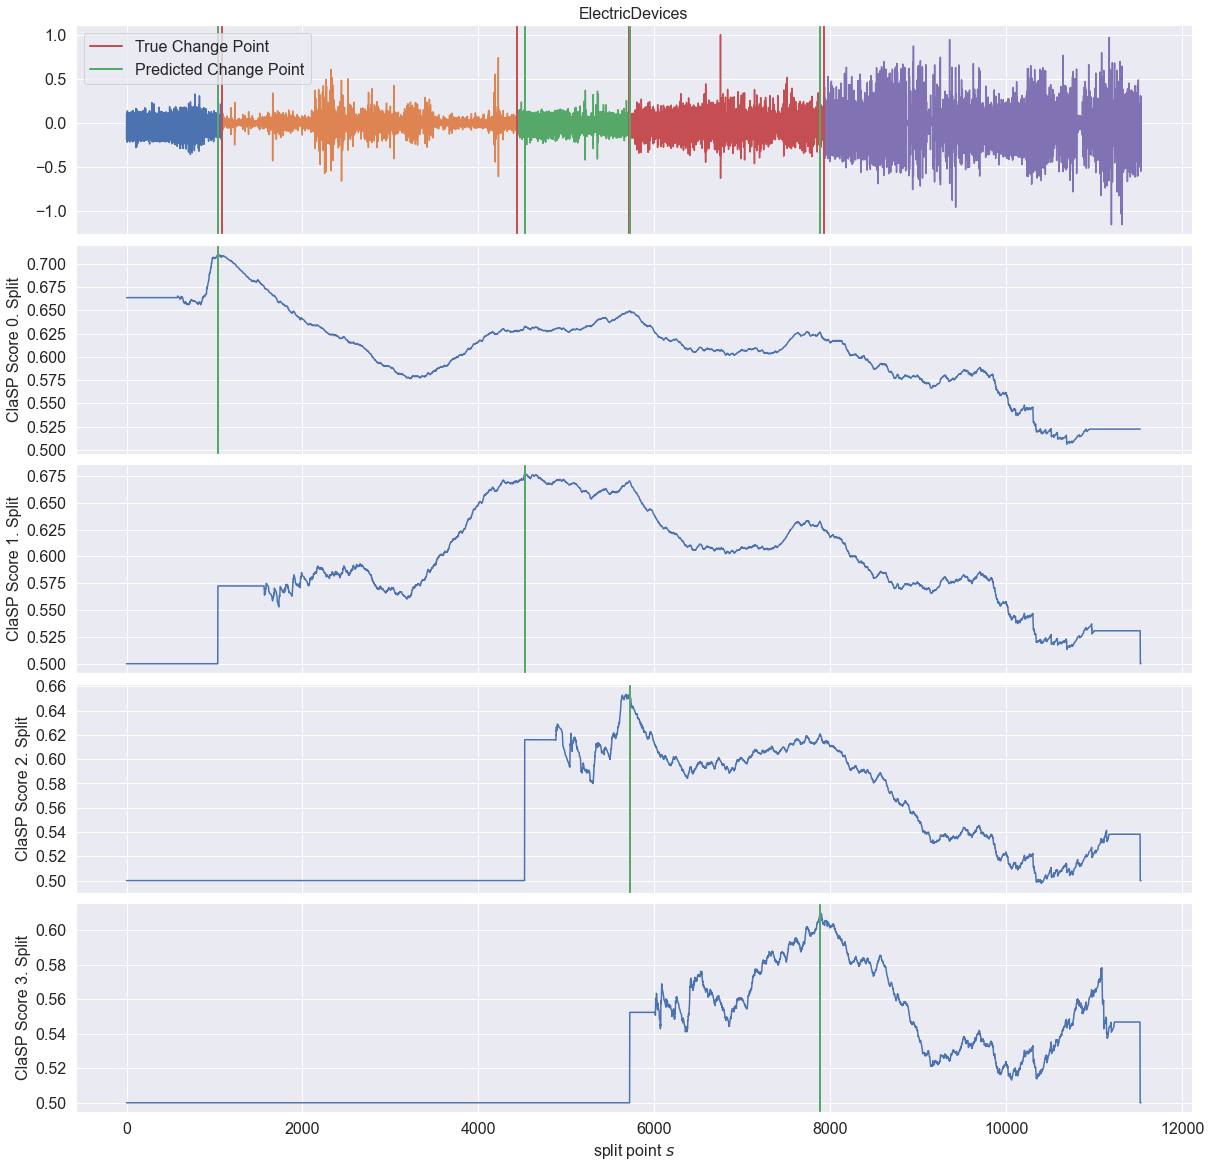

In [7]:
clasp = ClaSPSegmentation(period_length=dominant_period_size, n_cps=5).fit(ts)
found_cps, profiles, scores = clasp.predict(ts)

plot_clasp_with_ts(
    "ElectricDevices",
    np.array(ts),
    np.array(profiles),
    np.array(true_cps),
    np.array(found_cps),
)